In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import mne
import json

In [125]:
subject = "K312"
sample = "sample4"
sample_dir = f"../data/DataVIN/Official/{subject}/{sample}"

with open(f"{sample_dir}/scenario.json", mode="r", encoding="utf-8") as f:
    print(json.load(f))

raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=True, verbose=False)
raw.set_montage("standard_1005")

{'Recorder': 'Hòa', 'Location': 'HVQY', 'scenarioId': 4, 'Scenario': 'Nâng chân phải'}


<RawEDF | EEG.edf, 32 x 16640 (130.0 s), ~4.1 MB, data loaded>

In [126]:
raw = raw.filter(l_freq=8.0, h_freq=30.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 213 samples (1.664 sec)



In [127]:
anno = pd.DataFrame(raw.annotations)
anno

onset  duration          description                 orig_time
0   11.9724    7.2466             Thinking 2021-10-19 10:00:19+00:00
1   19.2199    5.3312              Resting 2021-10-19 10:00:19+00:00
2   24.5511    7.9807  Thinking and Acting 2021-10-19 10:00:19+00:00
3   32.5318    3.1655              Resting 2021-10-19 10:00:19+00:00
4   35.6973   10.0630             Thinking 2021-10-19 10:00:19+00:00
5   45.7613    6.5138              Resting 2021-10-19 10:00:19+00:00
6   52.2761    7.8970  Thinking and Acting 2021-10-19 10:00:19+00:00
7   60.1741    5.9139              Resting 2021-10-19 10:00:19+00:00
8   66.0880    8.1303             Thinking 2021-10-19 10:00:19+00:00
9   74.2183    5.8808              Resting 2021-10-19 10:00:19+00:00
10  80.1000    7.8632  Thinking and Acting 2021-10-19 10:00:19+00:00
11  87.9642    6.0477              Resting 2021-10-19 10:00:19+00:00
12  94.0119   35.9555               Typing 2021-10-19 10:00:19+00:00

In [71]:
events, event_id = mne.events_from_annotations(raw)

events

Used Annotations descriptions: ['Resting', 'Thinking', 'Thinking and Acting', 'Typing']


array([[ 2102,     0,     2],
       [ 2874,     0,     1],
       [ 4015,     0,     3],
       [ 4887,     0,     1],
       [ 5811,     0,     2],
       [ 6530,     0,     1],
       [ 7338,     0,     3],
       [ 8219,     0,     1],
       [ 8967,     0,     2],
       [ 9746,     0,     1],
       [10187,     0,     3],
       [11063,     0,     1],
       [11605,     0,     2],
       [12290,     0,     1],
       [12799,     0,     3],
       [13725,     0,     1],
       [14139,     0,     4]])

In [72]:
ts = list()
for i, r in anno[anno["description"] == "Thinking"].iterrows():
    # if i == 2:
    #     continue
    
    ts.append(raw.copy().crop(r["onset"], r["onset"] + r["duration"]))

In [187]:
raw_t = mne.concatenate_raws(ts)
raw_t

<RawEDF | EEG.edf, 32 x 2353 (18.4 s), ~638 kB, data loaded>

Opening raw-browser...


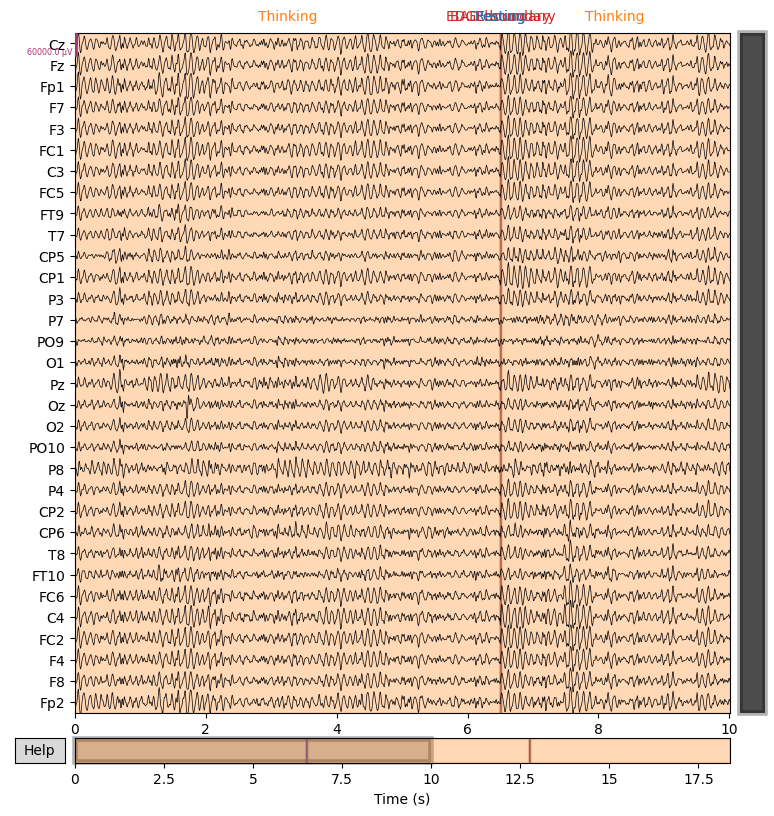

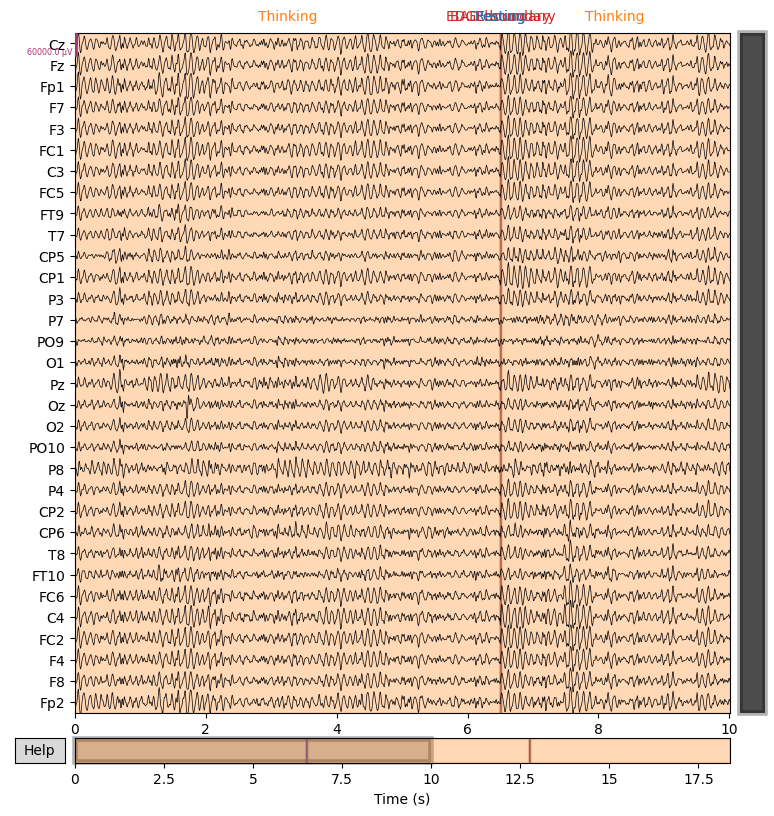

In [188]:
raw_t.plot(n_channels=32, scalings={"eeg": 3e-2})

Effective window size : 1.000 (s)


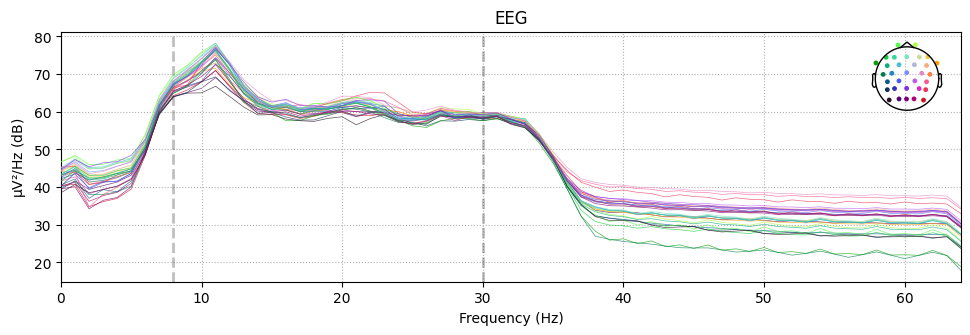

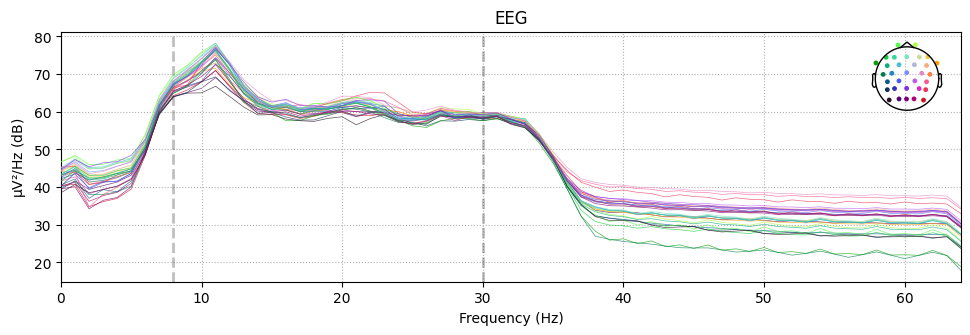

In [189]:
# for t in ts:
#     t.plot_psd(n_fft=128, n_overlap=64)
raw_t.plot_psd(n_fft=128, n_overlap=64)

In [190]:
events, event_id = mne.events_from_annotations(raw)

print(event_id)
events

Used Annotations descriptions: ['Resting', 'Thinking', 'Thinking and Acting', 'Typing']
{'Resting': 1, 'Thinking': 2, 'Thinking and Acting': 3, 'Typing': 4}


array([[  735,     0,     2],
       [ 1566,     0,     1],
       [ 3151,     0,     3],
       [ 3808,     0,     1],
       [ 4556,     0,     2],
       [ 5356,     0,     1],
       [ 5868,     0,     3],
       [ 6813,     0,     1],
       [ 7403,     0,     2],
       [ 8122,     0,     1],
       [ 8692,     0,     3],
       [ 9651,     0,     1],
       [10453,     0,     4]])

In [191]:
events.shape

(13, 3)

In [192]:
epochs = mne.Epochs(
    raw,
    events[np.where(events[:, 2] == 2)[0]],
    event_id=event_id,
    tmin=0,
    tmax=6,
    baseline=None,
    preload=True,
    proj=False,
    on_missing="ignore",
    event_repeated="drop",
    verbose=False,
)

    Using multitaper spectrum estimation with 7 DPSS windows


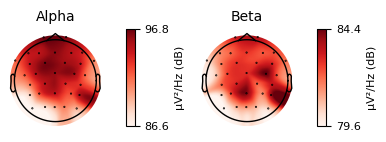

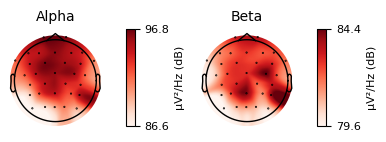

In [193]:
epochs.plot_psd_topomap(bands=[(8, 12, "Alpha"), (12, 30, "Beta")])

In [194]:
evoked = epochs.average()

No projector specified for this dataset. Please consider the method self.add_proj.


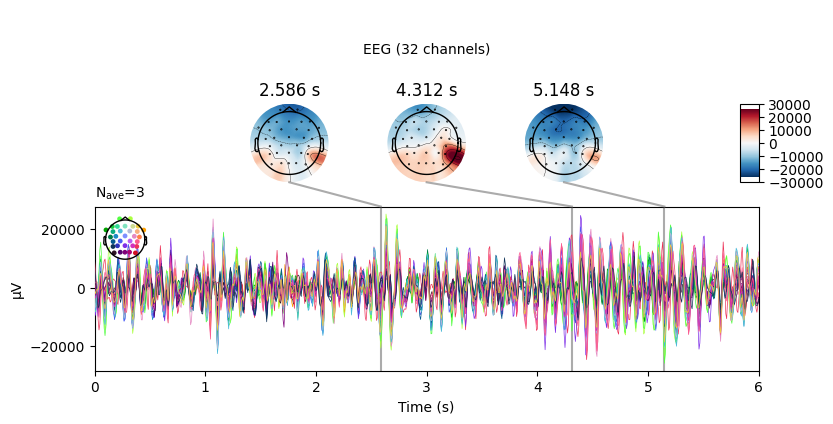

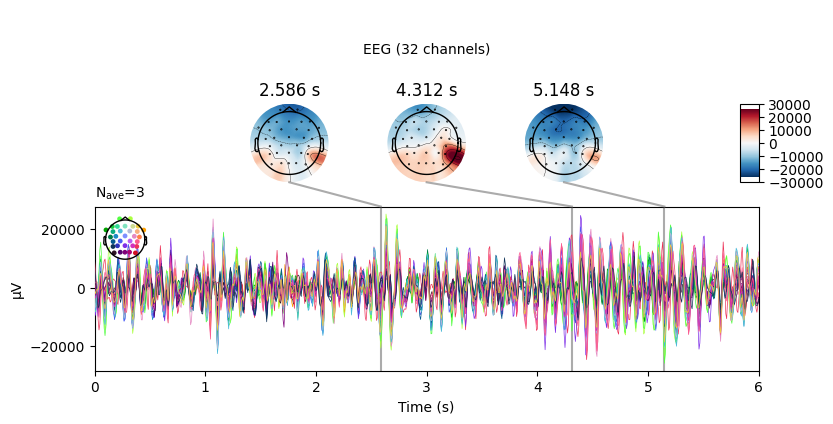

In [195]:
evoked.plot_joint()

In [128]:
%%time
ica = mne.preprocessing.ICA(n_components=32, max_iter=5000, random_state=42)
ica.fit(raw)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 32 components


KeyboardInterrupt: 

In [129]:
ica.plot_components()

AttributeError: 'ICA' object has no attribute 'mixing_matrix_'

In [ ]:
anno

In [ ]:
ica.exclude = []

ica.plot_sources(raw, start=45)

Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


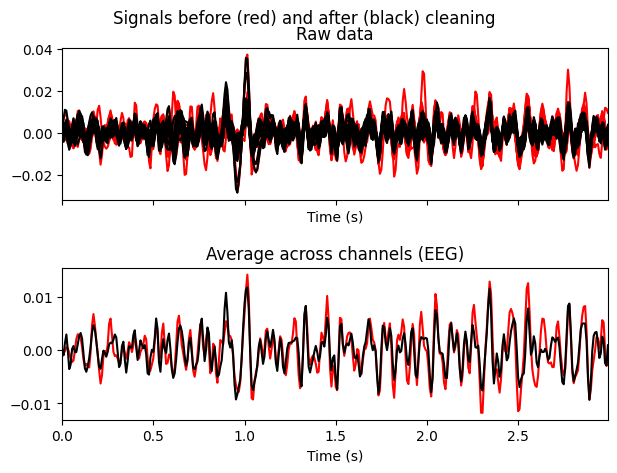

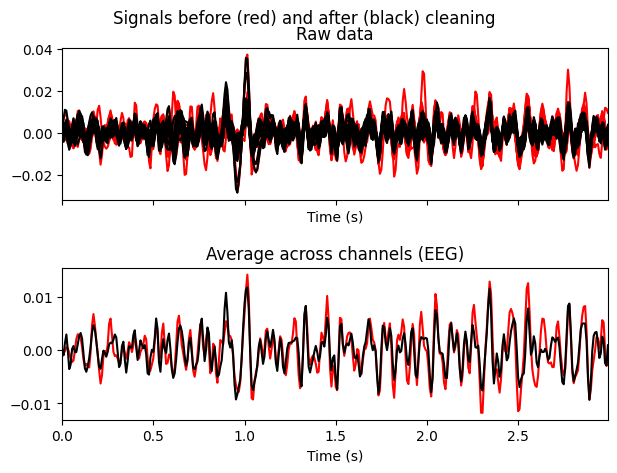

In [63]:
ica.plot_overlay(raw, exclude=[0,1])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


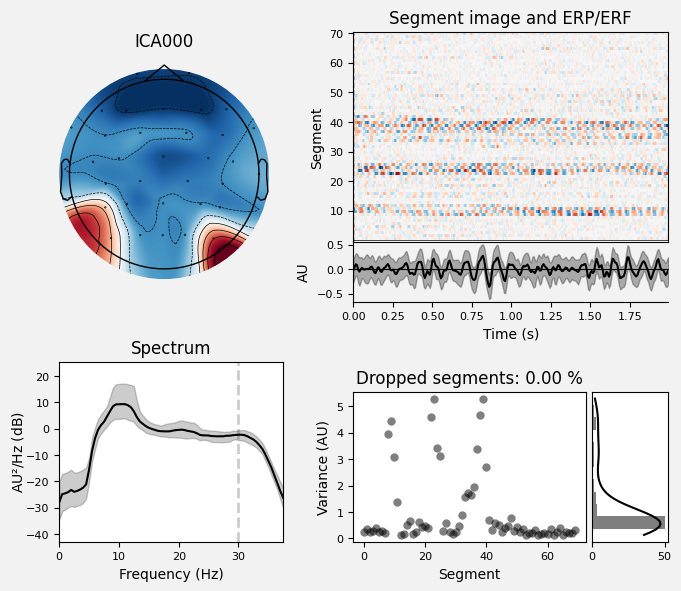

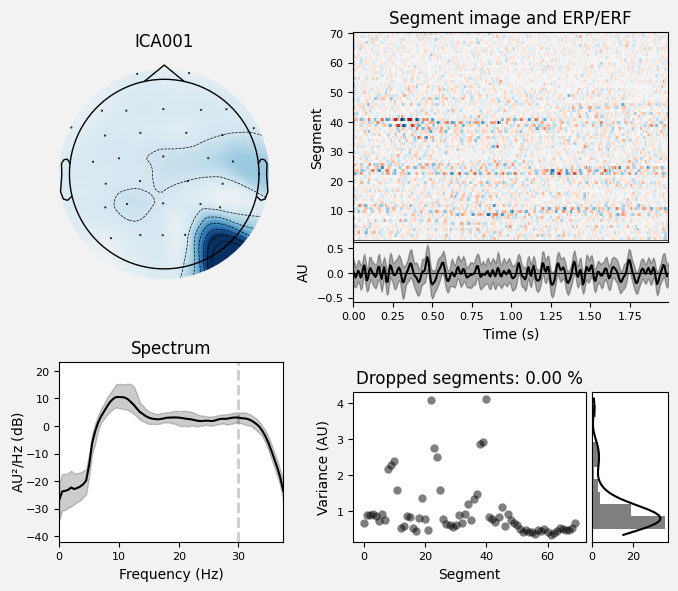

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [66]:
ica.plot_properties(raw, picks=[0,1])

In [67]:
ica.exclude = [0,1]

reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


<RawEDF | EEG.edf, 32 x 17920 (140.0 s), ~4.4 MB, data loaded>

Opening raw-browser...


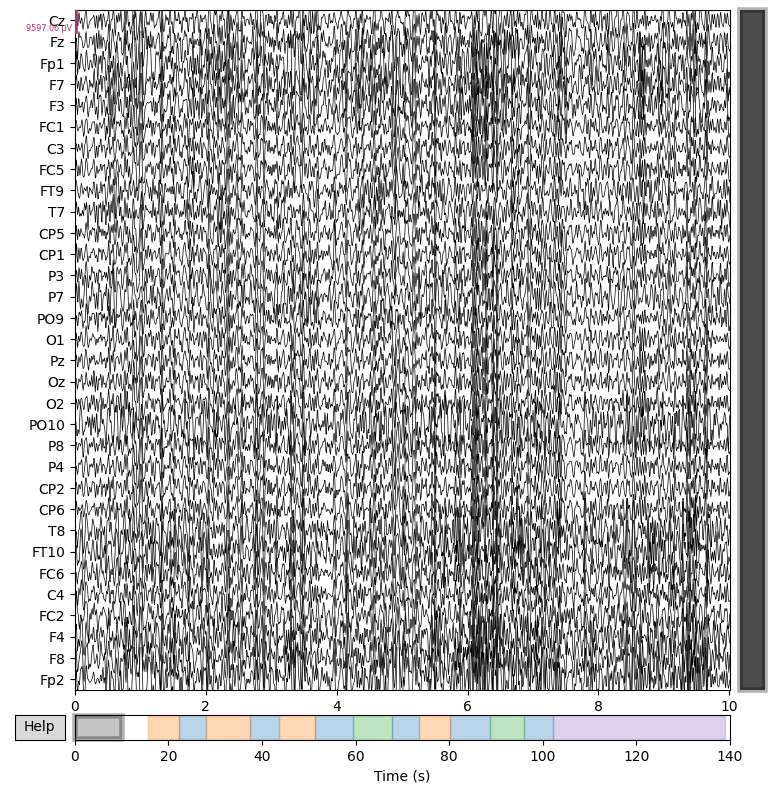

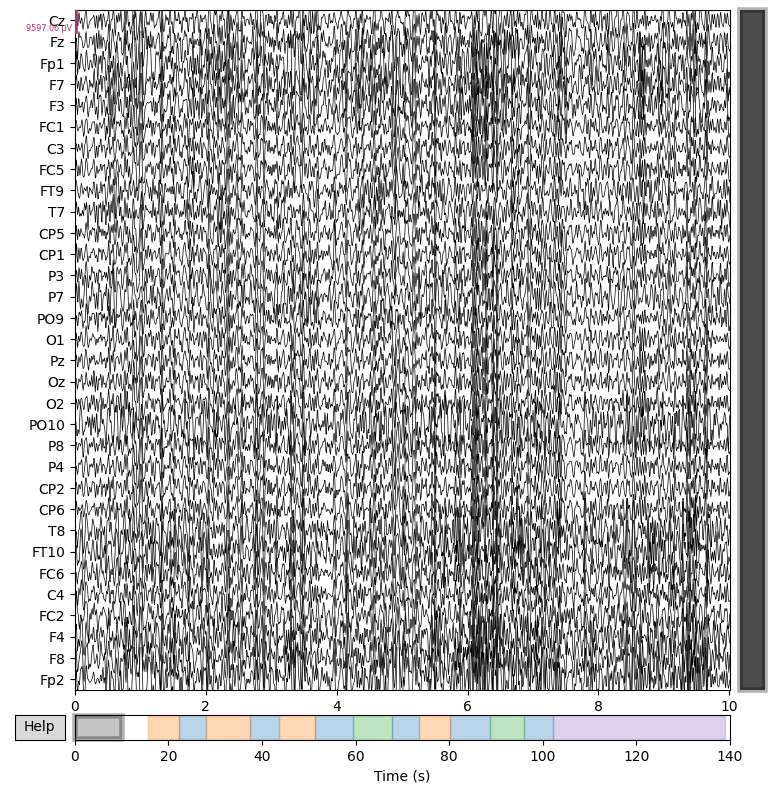

In [68]:
reconst_raw.plot(n_channels=32, scalings="auto")

In [69]:
reconst_epochs = mne.Epochs(
    reconst_raw,
    events[np.where(events[:, 2] == 2)[0]],
    event_id=event_id,
    tmin=0,
    tmax=6,
    baseline=None,
    preload=True,
    proj=False,
    on_missing="ignore",
    event_repeated="drop",
    verbose=False,
)

    Using multitaper spectrum estimation with 7 DPSS windows


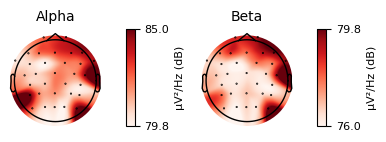

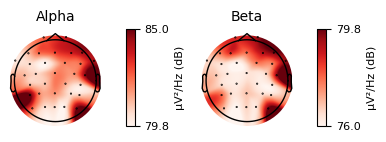

In [70]:
reconst_epochs.plot_psd_topomap(bands=[(8, 12, "Alpha"), (12, 30, "Beta")])